In [66]:
!pip install --upgrade gspread

Requirement already up-to-date: gspread in /usr/local/lib/python3.7/dist-packages (3.7.0)


In [67]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())


In [68]:
# open the file in your browser in advance
worksheet = gc.open('labeling_190331').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows[1])

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df.head(5)

['1', '0', '売買基本契約書', 'タイトル', '1', '', '', '', '', '', '', '', '', '', '', '', '', '2', '1', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


,file_no,line_no,text,label,タイトル,前文,章,条,項,号,リスト,その他(条項内),末文,締結日,サイン,ページ番号,その他(条項外),check用,label_title,label_bracketed,label_notice_start,label_notice_end,label_index_line,label_empty,label_chapter_index_line,label_article_index_line,label_conclusion,label_preamble,label_date,label_only_date,label_name,label_party,label_signature,label_address,label_ignored,label_others
0,1,0,売買基本契約書,タイトル,1,,,,,,,,,,,,,2,1,,,,,,,,,,,,,,,,,
1,1,1,,,,,,,,,,,,,,,,0,,,,,,1,,,,,,,,,,,,
2,1,2,,,,,,,,,,,,,,,,0,,,,,,1,,,,,,,,,,,,
3,1,3,買主今泉貴嗣（以下「買主」という。）と売主堅山耀太郎（以下「売主」という。）とは、●●●●（...,前文,,1,,,,,,,,,,,,2,,,,,,,,,,1,,,,,,,,
4,1,4,,,,,,,,,,,,,,,,0,,,,,,1,,,,,,,,,,,,


In [69]:
import numpy as np
np.unique(df[['file_no']].values.flatten()).shape

(278,)

In [70]:
!pip install transformers==3.0.2

In [71]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 gcc g++ git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
gcc is already installed at the requested version (4:7.4.0-1ubuntu2.3)
g++ is already installed at the requested version (4:7.4.0-1ubuntu2.3)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-

In [72]:
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])

lists = df[['条', '項', '号']].replace('', '0').astype(int).values.tolist()
df['target'] = lists
new_df = df[['text', 'target']].copy()
new_df.head(20)

,text,target
0,売買基本契約書,"[0, 0, 0]"
1,,"[0, 0, 0]"
2,,"[0, 0, 0]"
3,買主今泉貴嗣（以下「買主」という。）と売主堅山耀太郎（以下「売主」という。）とは、●●●●（...,"[0, 0, 0]"
4,,"[0, 0, 0]"
5,第１条（基本契約性）,"[1, 0, 0]"
6,１ 本契約は、売主と買主との間に締結される本件製品の個別売買に共通に適用される。,"[0, 1, 0]"
7,２ 本契約と異なる契約条件の合意は、両者の書面による合意によらない限り、その効力を有しないも...,"[0, 1, 0]"
8,,"[0, 0, 0]"
9,第２条（個別売買契約の締結）,"[1, 0, 0]"


In [73]:
np.log10(200)

2.3010299956639813

38.5, 38.8, 27.0


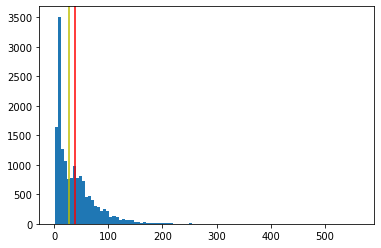

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def array_for(x):
    return np.array([len(xi) for xi in x if len(xi) > 0])  # np.log10

x = array_for(new_df.text.values)

# x: array of 1-d scalars
print(f'{np.mean(x):.03}, {np.std(x):.03}, {np.median(x)}')
plt.hist(x, bins=100)
plt.axvline(x.mean(), color='r')
plt.axvline(np.median(x), color='y')
plt.show()

In [75]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


# Sections of config

modelname = 'cl-tohoku/bert-base-japanese-char'

# Defining some key variables that will be used later on in the training
N_CLASS = 3
MAX_LEN = 150
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained(modelname)

class CustomDataset(Dataset):

    def __init__(
        self,
        dataframe,
        tokenizer,
        max_len,
        text_colname='text',
        target_colname='target',
    ):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[text_colname]
        self.targets = dataframe[target_colname]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # tokenized_text = self.tokenizer.tokenize(text)
        # indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        # tokens_tensor = torch.tensor([indexed_tokens])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }



# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# DataLoader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)



FULL Dataset: (25473, 2)
TRAIN Dataset: (20378, 2)
TEST Dataset: (5095, 2)


In [76]:
train_dataset.to_csv("train_dataset.tsv", sep="\t")
new_df.to_csv("full_dataset.tsv", sep="\t")
test_dataset.to_csv("test_dataset.tsv", sep="\t")

In [77]:
!ls

adc.json  full_dataset.tsv  test_dataset.tsv
drive	  sample_data	    train_dataset.tsv


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!cp train_dataset.tsv /content/drive/My\ Drive/

In [80]:
!cp test_dataset.tsv /content/drive/My\ Drive/

In [81]:
!cp full_dataset.tsv /content/drive/My\ Drive/

In [82]:
ls

adc.json  full_dataset.tsv  test_dataset.tsv
drive/    sample_data/      train_dataset.tsv


In [83]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self, model_name):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained(model_name)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, N_CLASS)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'{device} is used')
model = BERTClass(modelname)
model.to(device)

optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

def train(epoch):
    model.train()
    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if i % 100 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i > 1000:
            break

for epoch in range(EPOCHS):
    train(epoch)

cuda is used
Epoch: 0, Loss:  0.7692997455596924
Epoch: 0, Loss:  0.26249200105667114
Epoch: 0, Loss:  0.1669023036956787
Epoch: 0, Loss:  0.10579144954681396
Epoch: 0, Loss:  0.0680907666683197
Epoch: 0, Loss:  0.10830317437648773
Epoch: 0, Loss:  0.12123662233352661
Epoch: 0, Loss:  0.050610702484846115
Epoch: 0, Loss:  0.1580764353275299
Epoch: 0, Loss:  0.026354797184467316
Epoch: 0, Loss:  0.04863592982292175


In [84]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    precision_score_micro = metrics.precision_score(targets, outputs, average='micro')
    recall_score_micro = metrics.recall_score(targets, outputs, average='micro')
    print(f"Accuracy Score = {accuracy}")   # Accuracyだけ見るのは意味ないと指摘
    print(f"P Score (Micro) = {precision_score_micro}")
    print(f"R Score (Micro) = {recall_score_micro}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9485770363101079
P Score (Micro) = 0.9170344218887908
R Score (Micro) = 0.9260249554367201
F1 Score (Micro) = 0.9215077605321508
F1 Score (Macro) = 0.9029292486342744


## BaseLine
Accuracy Score = 0.9556427870461236    
P Score (Micro) = 0.9314641744548287    
R Score (Micro) = 0.9327094474153298    
F1 Score (Micro) = 0.9320863950122467    
F1 Score (Macro) = 0.9177879192183686    

In [85]:
outputs = [list(map(int, b)) for b in outputs.tolist()]

In [86]:
len(outputs), len(targets), len(targets[0])

(5095, 5095, 3)

In [87]:
print(targets[0])

[1.0, 0.0, 0.0]


In [88]:
print(test_dataset.iloc[0])

text      買主今泉貴嗣（以下「買主」という。）と売主堅山耀太郎（以下「売主」という。）とは、●●●●（...
target                                            [0, 0, 0]
Name: 0, dtype: object


In [89]:
tp_j, fp_j, fn_j, tp_k, fp_k, fn_k, tp_g, fp_g, fn_g = 0,0,0,0,0,0,0,0,0
for (jp, kp, gp), (jg, kg, gg) in zip(outputs, targets):
  if jg==1:
    if jp==1:
      tp_j+=1
    else:
      fn_j+=1
  if jp==1:
    if jg!=1:
      fp_j+=1

  if kg==1:
    if kp==1:
      tp_k+=1
    else:
      fn_k+=1
  if kp==1:
    if kg!=1:
      fp_k+=1

  if gg==1:
    if gp==1:
      tp_g+=1
    else:
      fn_g+=1
  if gp==1:
    if gg!=1:
      fp_g+=1
p_j, r_j = tp_j / (tp_j+fp_j), tp_j / (tp_j+fn_j)
f1_j = 2 / (1/p_j + 1/r_j)
p_k, r_k = tp_k / (tp_k+fp_k), tp_k / (tp_k+fn_k)
f1_k = 2 / (1/p_k + 1/r_k)
p_g, r_g = tp_g / (tp_g+fp_g), tp_g / (tp_g+fn_g)
f1_g = 2 / (1/p_g + 1/r_g)
print(tp_j, fp_j, fn_j, p_j, r_j, f1_j)
print(tp_k, fp_k, fn_k, p_k, r_k, f1_k)
print(tp_g, fp_g, fn_g, p_g, r_g, f1_g)

668 38 30 0.9461756373937678 0.9570200573065902 0.9515669515669517
1129 135 33 0.8931962025316456 0.9716006884681584 0.9307502061005771
281 15 103 0.9493243243243243 0.7317708333333334 0.8264705882352941


In [90]:
# outputs, targets = validation(epoch)
# outputs_max = [[0,0,0] for _ in outputs]
# for omax, o in zip(outputs_max, outputs):
#   omax[np.argmax(o)] = 1

In [91]:
# 学習とテストの分割
### 契約書単位のsplitをしてるか

from sklearn.model_selection import train_test_split

# X = df[['text']]
# y = df[['label']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

### 契約書単位のsplit
fileno2df = {fileno: _df[['text', 'label']] for fileno, _df in df.set_index('file_no').groupby(level=0)}
train_fileno, test_fileno = train_test_split(list(fileno2df.keys()), test_size=0.33, random_state=42, shuffle=False)
X_train = [fileno2df[fileno][['text']] for fileno in train_fileno]
y_train = [fileno2df[fileno][['label']] for fileno in train_fileno]
X_test = [fileno2df[fileno][['text']] for fileno in test_fileno]
y_test = [fileno2df[fileno][['label']] for fileno in test_fileno]

In [92]:
# CV

import numpy as np
from sklearn.model_selection import KFold

def f(row):
  if row['条']:
    return '条' 
  if row['項']:
    return '項'
  if row['号']:
    return '号'
  return ''

df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df['label'] = df.apply(f, axis=1)

X = []
y = []
for fileno, _df in df.set_index('file_no').groupby(level=0):
  texts = _df[['text']].values.flatten()
  labels = _df[['label']].values.flatten()
  X.append(texts)
  y.append(labels)
X = np.array(X)
y = np.array(y)


kfold = KFold(n_splits=5)
for train_index, test_index in kfold.split(X, y):
  print(f"TRAIN:{len(train_index)}", train_index, f"TEST:{len(test_index)}", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # print(X_train, X_test)
  # print(y_train, y_test)

TRAIN:222 [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277] TEST:56 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## 検証
- データの特徴
 - 「条」の次に「項」が0〜N行入る。その後に「号」が0〜n行入る
 - 第X条と始まる項目に「条」が多いが、（研究内容）「条」のあとに第X条〜という文面ではいるケースも有る。おそらく同一文書内においては、スタイルは統一される
 - 「条」は体言止めで表現される？
 - 「項」は文章あるいは、途中分割された文章となる？
 - 「項」はXXとする。XXと定める。XXする。XX出来る。ならない。ない。のような文末になる
 - 「条」の次のLineは必ず「項」になる？　->　条自体に内容が書かれているケースもある（line14015)
 -  単文が与えられたときに「項」と「号」はどうやって見分ける？

 
- 考えられるアプローチと優先順位
（データの確認）
 - 「条」「項」における単語の出現頻度を確認する
 - 「条」「項」における単語の重複度合いを確認する
 （アプローチ）
 - BERTが誤って分類したものを確認する
  - それがルールベースで拾えそうかどうか確認し、出来そうなら試す
  - BERTの最終層を出力し、他の分類器に掛ける  
  - 文書ごとのスタイルを判定する分類器とBERTのclassifierを組み合わせてみる
  - BERTに追加のpre-trainで法律ドメインのMLMを学習させたあとにclassificationする
- 懸念点、注意事項
 - ひとまずなし。

## 単語の出現頻度

In [93]:
jou_df = df[df["条"]=="1"]
kou_df = df[df["項"]=="1"]

In [94]:
jou_df.iloc[0].text

'第１条（基本契約性）'

In [95]:
import MeCab
mecab = MeCab.Tagger("-Owakati")

In [96]:
def word_counter(df, column, mecabtagger):
  words = {}
  for idx, item in df.iterrows():
    item_words = mecabtagger.parse(item[column]).split()
    for word in item_words:
        words[word] = words.get(word, 0) + 1

  # word数順
  result = [(v, k) for k, v in words.items()]
  result.sort()
  result.reverse()
  return result

In [97]:
jou_words = word_counter(jou_df, "text", mecab)
kou_words = word_counter(kou_df, "text", mecab)

In [99]:
print(len(jou_words))
print(len(kou_words))

1609
3641


In [100]:
jou_words[0]

(2785, '（')

In [101]:
jou_words[0][1]

'（'

In [110]:
# top100
n = 100
j_topn = jou_words[:n]
k_topn = kou_words[:n]

dup_w = []
only_j_w = []
only_k_w = []

k_w = []
for item in k_topn:
  k_w.append(item[1])
  item[1]

j_w = []
for w in j_topn:
  j_w.append(w[1])
  if w[1] not in k_w:
    only_j_w.append(w)
  else:
    dup_w.append(w[1])

for w in k_topn:
  if w[1] not in dup_w:
    only_k_w.append(w)


In [111]:
print("Top100")
print("両方に存在: {}".format(dup_w))
print("条のみに存在: {}".format(only_j_w))
print("項のみに存在: {}".format(only_k_w))

Top100
両方に存在: ['（', '）', '第', '条', 'の', '、', '１', 'を', 'は', '契約', '○', 'に', '。', '乙', 'する', '甲', 'し', '２', 'と', '３', 'た', 'が', '等', '期間', '権', '本', '及び', '金', 'て', '解除', '協議', 'もの', '本件', 'ない', 'とき', '日', '損害', '・', '負担', '業務', 'に対し', '年', '所有', '生じ', '又は', 'まで', '使用', 'こと', '上', '委託', 'から', 'による', '的', '場合', 'この', 'について', 'その', '者', '甲乙', 'これ']
条のみに存在: [(343, '\\'), (237, '４'), (234, '５'), (214, '６'), (191, '７'), (171, '８'), (147, '９'), (135, '管轄'), (134, '０'), (132, '）\\'), (122, '義務'), (115, '譲渡'), (107, '合意'), (104, '目的'), (103, '事項'), (99, '秘密'), (98, '禁止'), (92, '支払'), (90, '条項'), (86, '保証'), (84, '保持'), (82, '平成'), (81, '代金'), (79, '賠償'), (78, '移転'), (78, '支払う'), (77, '円'), (75, '売買'), (74, '費用'), (68, '解決'), (68, '終了'), (67, '権利'), (65, '責任'), (65, '('), (64, '登記'), (64, '期限'), (63, '条件'), (63, '丙'), (62, ')'), (61, '方法')]
項のみに存在: [(1135, 'で'), (914, 'さ'), (811, 'により'), (796, 'できる'), (763, '，'), (708, 'なら'), (638, '前項'), (631, '相手方'), (615, 'れ'), (579, '物'), (579, 'な'), (555, '

In [112]:
 ## 全件
j_topn = jou_words
k_topn = kou_words

dup_w = []
only_j_w = []
only_k_w = []

k_w = []
for item in k_topn:
  k_w.append(item[1])
  item[1]

j_w = []
for w in j_topn:
  j_w.append(w[1])
  if w[1] not in k_w:
    only_j_w.append(w)
  else:
    dup_w.append(w[1])

for w in k_topn:
  if w[1] not in dup_w:
    only_k_w.append(w)

print("全件")
print("両方に存在: {}".format(dup_w))
print("条のみに存在: {}".format(only_j_w))
print("項のみに存在: {}".format(only_k_w))



全件
両方に存在: ['（', '）', '第', '条', 'の', '、', '１', 'を', 'は', '契約', '○', 'に', '。', '乙', 'する', '甲', 'し', '２', 'と', '\\', '３', 'た', 'が', '等', '４', '５', '期間', '６', '権', '本', '７', '及び', '金', '８', 'て', '解除', '協議', '９', 'もの', '本件', 'ない', '管轄', 'とき', '０', '日', '損害', '・', '義務', '負担', '業務', 'に対し', '譲渡', '年', '合意', '所有', '目的', '事項', '秘密', '禁止', '生じ', '又は', '支払', 'まで', '条項', '使用', 'こと', '保証', '保持', '上', '平成', '委託', '代金', '賠償', '移転', '支払う', 'から', '円', '売買', '費用', 'による', '的', '場合', 'この', 'について', 'その', '解決', '者', '終了', '権利', '責任', '(', '登記', '甲乙', '期限', '条件', '丙', 'これ', ')', '方法', '内容', '.', '変更', '各', '定め', '情報', '裁判所', '1', '報告', '販売', '物', '利益', '貸借', '次', 'もっ', '物件', '有効', '債務', '後', '疑義', '研究', '引渡し', 'につき', '誠意', '解約', 'として', 'で', '解釈', '第三者', 'も', '再', '報酬', '営業', '前条', '連帯', '手続', '土地', '担保', 'ため', '直ちに', '支払い', 'なら', '管理', '法', 'に対する', 'できる', 'および', '遅延', '返還', '実施', '商品', '以下', '】', '【', '社会', '提供', '個別', 'により', '瑕疵', '排除', 'な', 'その他', '賃料', '納入', '時', '成果', '反', '危険', '勢力', '限り', '遂行', '誠実', '消

In [113]:
print(len(only_k_w))

2196


In [114]:
# 30件以上の項
for item in only_k_w:
  if item[0] > 29:
    print(item)

(523, '当該')
(150, 'せ')
(132, '="')
(124, '含む')
(108, '産業')
(78, '基づい')
(78, 'span')
(78, 'id')
(78, 'class')
(78, 'anchor')
(78, '"')
(74, '除き')
(70, '本条')
(67, '生じる')
(67, '希望')
(66, '<')
(65, '責め')
(60, '求め')
(59, '全て')
(57, '">')
(56, '負わ')
(56, '行っ')
(56, '掲げる')
(52, 'う')
(50, '基準')
(47, '過失')
(47, 'あるいは')
(46, '］')
(46, '［')
(46, '是正')
(46, 'Text')
(44, '合理')
(44, 'いかなる')
(43, '発見')
(43, 'ご')
(42, '日本')
(42, 'ソフトウェア')
(42, 'カ月')
(41, '時点')
(41, 'すみやか')
(41, '●')
(40, '法律')
(39, '変動')
(39, '別段')
(38, '活用')
(38, '本店')
(38, '故意')
(38, '振り込ん')
(37, '除く')
(37, '同じ')
(36, '標ぼう')
(36, '事情')
(36, 'ゴロ')
(35, 'Ｂ')
(35, '媒介')
(34, '起算')
(34, 'ユーザ')
(33, '属する')
(33, '地変')
(32, '適切')
(32, '追加')
(32, '準ずる')
(32, 'さらに')
(31, '当たり')
(31, '委員')
(31, '前日')
(31, '例')
(31, '付し')
(31, 'システム')
(30, '図書')
(30, '動産')
(30, 'に際し')


### 考察

※以降の(数字, 単語）の数字は出現回数を示している

- TOP100で見ると、項のみに存在する単語として、「(1135, 'で'), (811, 'により'), (763, '，'), (708, 'なら'), (638, '前項')」などがあり、複数文を前提とした単語はほぼ入らないように思われるが、全件だと消えていることから、一部のレアケースでは、条にも含まれる場合があると推定される
- ドキュメントのパースの問題と思われるが、項のみspan, id, classなどのタグが見られた
- 全件で見たときに有効と思われるのが、「(523, '当該')、(124, '含む')、(78, '基づい')、(74, '除き')、(67, '生じる')、(47, 'あるいは')、(44, 'いかなる')、(32, '準ずる')、(32, 'さらに')、(31, '当たり')、(30, 'に際し')」辺りであり、これれは前記複数文を想定した場合の単語と合致する。ただし、有効と思われた「により、前項」等は全件だと除外されてしまっているため、未知の文書に対して必ずしも当てはまるとは断言できない。
- (70, '本条')は、自身が条であるときには使わない単語であることが推察されるため、ルールベースに入れても問題がないと想定される。


# BERTが誤って分類したものを確認する

メモ:データのチェックとモデルの保存

In [117]:
testing_loader

In [120]:
for idx, data in enumerate(testing_loader, 0):
  if idx == 0:
    test_data = data

In [121]:
test_data

{'ids': tensor([[   2,    1,  173, 1003,    1,  554, 1198,  666,  166,  284,    6,  929,
           571,   12,    7, 1921,    1,  451,  929,    1,   10, 2356,    3,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

In [125]:
test_data["ids"]

tensor([[   2,    1,  173, 1003,    1,  554, 1198,  666,  166,  284,    6,  929,
          571,   12,    7, 1921,    1,  451,  929,    1,   10, 2356,    3,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [126]:
test_data["ids"][0]

tensor([   2,    1,  173, 1003,    1,  554, 1198,  666,  166,  284,    6,  929,
         571,   12,    7, 1921,    1,  451,  929,    1,   10, 2356,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [127]:
tokenizer.convert_ids_to_tokens(test_data["ids"][0])

['[CLS]',
 '[UNK]',
 '前',
 '項',
 '[UNK]',
 '派',
 '遣',
 '従',
 '業',
 '員',
 'の',
 '給',
 '与',
 'は',
 '、',
 '乙',
 '[UNK]',
 '支',
 '給',
 '[UNK]',
 '。',
 '\\',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]

In [138]:
for data in test_data["ids"]:
  i_to_w = tokenizer.convert_ids_to_tokens(data)
  s = ""
  for word in i_to_w:
    if word not in ['[PAD]']:
      s += word
  print(s)

[CLS][UNK]前項[UNK]派遣従業員の給与は、乙[UNK]支給[UNK]。\[SEP]
[CLS][SEP]
[CLS][UNK]甲は、乙に対し、本著作物を以下の形式[UNK]、平成○年○月末日[UNK]、納入[UNK]。[SEP]
[CLS][SEP]


### あとあとのためファイル保存

In [128]:
# Saving the files for re-use

output_model_file = 'pytorch_bertmodel_contract.bin'
output_vocab_file = 'vocab_contract.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')


All files saved


In [130]:
!ls

adc.json  full_dataset.tsv		  sample_data	    train_dataset.tsv
drive	  pytorch_bertmodel_contract.bin  test_dataset.tsv  vocab_contract.bin


In [ ]:
!cp pytorch_bertmodel_contract.bin drive/MyDrive/

In [131]:
!cp pytorch_bertmodel_contract.bin /content/drive/My\ Drive/

In [132]:
!cp vocab_contract.bin /content/drive/My\ Drive/

### 考察

- 公開されているTokenizerを使っているために、（おそらく記号にて）[UNK]が出てしまっている。そのため、tokenizerをSentencePieceに変更、またはMecabで利用したものに対してのBPEを掛けるなどの処理を行い、ドメイン文書を語彙獲得のリソースに追加する、あるいはUNKとなった単語をvocabに追加することで、UNKの量をへらすことが出来、精度の改善が見られる可能性がある。（ただし、単語idが既存のものとは、合わなくなるためpre-trainからのやり直しは必要となる）


In [141]:

def validation_indices(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_ids = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            fin_ids.extend(ids.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets, fin_ids

for epoch in range(EPOCHS):
    outputs, targets, indices = validation_indices(epoch)
    outputs = np.array(outputs) >= 0.5

In [142]:
outputs

array([[ True, False, False],
       [ True, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False,  True, False],
       [False,  True, False]])

In [150]:
len(outputs) == len(targets) == len(indices)

True

In [151]:
outputs[0]

array([ True, False, False])

In [152]:
targets[0]

[1.0, 0.0, 0.0]

In [153]:
outputs[0] == targets[0]

array([ True,  True,  True])

In [196]:
errors = []
for idx in range(len(outputs)):
  arr = outputs[idx] == targets[idx]
  if arr.all():
    continue
  else:
    s = ""
    token_li = tokenizer.convert_ids_to_tokens(indices[idx])
    for token in token_li:
      if token not in ['[PAD]']:
        s += token
    print("error_text: {}".format(s))
    print("Prediction: {}".format(outputs[idx]))
    print("Correct Answer: {}".format(targets[idx]))
    errors.append(s)


error_text: [CLS][UNK]建物の表示[UNK][SEP]
Prediction: [ True False False]
Correct Answer: [0.0, 0.0, 0.0]
error_text: [CLS][UNK]乙が当該派遣労働者を休業[UNK][SEP]
Prediction: [False  True False]
Correct Answer: [0.0, 0.0, 0.0]
error_text: [CLS]二、残代金[UNK]円を平成[UNK]年[UNK]月[UNK]日[UNK]後記表示の建物の所有権移転登記申請並[UNK]敷地の所有者[UNK][UNK]以下、「丙」[UNK]。[UNK]の借地権譲渡の承諾書の交付と引換[UNK]支払う。[SEP]
Prediction: [False  True False]
Correct Answer: [0.0, 0.0, 1.0]
error_text: [CLS][UNK]秒、[UNK]秒、[UNK]秒、5分の各[UNK]制作[UNK]。[SEP]
Prediction: [False  True False]
Correct Answer: [0.0, 0.0, 1.0]
error_text: [CLS]売主[UNK]甲、買主[UNK]乙、乙の連帯保証人[UNK]丙[UNK]、該当事者間[UNK]、土地建物分譲[UNK]、次の通り契約を締結[UNK]。[SEP]
Prediction: [False  True False]
Correct Answer: [0.0, 0.0, 0.0]
error_text: [CLS][UNK]利息の支払日毎月[UNK]日[SEP]
Prediction: [False False False]
Correct Answer: [0.0, 0.0, 1.0]
error_text: [CLS][UNK]連絡先及び連絡方法[UNK][SEP]
Prediction: [ True False False]
Correct Answer: [0.0, 0.0, 0.0]
error_text: [CLS][UNK]回収[UNK]金員を全て回収[UNK]場合。[SEP]
Prediction: [False  True False]
Cor

In [192]:
errors

['[CLS][UNK]建物の表示[UNK][SEP]',
 '[CLS][UNK]乙が当該派遣労働者を休業[UNK][SEP]',
 '[CLS]二、残代金[UNK]円を平成[UNK]年[UNK]月[UNK]日[UNK]後記表示の建物の所有権移転登記申請並[UNK]敷地の所有者[UNK][UNK]以下、「丙」[UNK]。[UNK]の借地権譲渡の承諾書の交付と引換[UNK]支払う。[SEP]',
 '[CLS][UNK]秒、[UNK]秒、[UNK]秒、5分の各[UNK]制作[UNK]。[SEP]',
 '[CLS]売主[UNK]甲、買主[UNK]乙、乙の連帯保証人[UNK]丙[UNK]、該当事者間[UNK]、土地建物分譲[UNK]、次の通り契約を締結[UNK]。[SEP]',
 '[CLS][UNK]利息の支払日毎月[UNK]日[SEP]',
 '[CLS][UNK]連絡先及び連絡方法[UNK][SEP]',
 '[CLS][UNK]回収[UNK]金員を全て回収[UNK]場合。[SEP]',
 '[CLS]代替商品を無償で提供[UNK]、本製品の代金の全額を返還[UNK]。[SEP]',
 '[CLS][UNK][UNK]積替保管[UNK][SEP]',
 '[CLS]算に入[UNK]。[SEP]',
 '[CLS]甲国立大学法人広島大学[UNK][SEP]',
 '[CLS][UNK],[UNK][UNK],[UNK][SEP]',
 '[CLS]乙は、下記の場所[UNK]、甲の就業規則[UNK]他諸規程及び甲の指揮に従い、誠実に行[UNK]。[SEP]',
 '[CLS][UNK][UNK]調停段階[UNK]受任の場合の着手金の金額は金[UNK]円[UNK][UNK]訴訟に移行[UNK][SEP]',
 '[CLS][UNK][UNK]調査\\[SEP]',
 '[CLS][UNK]受託研究に従事[UNK]者[UNK][SEP]',
 '[CLS]を履行[UNK]、営業者に対[UNK]適用[UNK]一切の法令、定款、社内規則又は営[SEP]',
 '[CLS]但し、年月日[UNK]年月日[UNK]試用期間[UNK]、[SEP]',
 '[CLS][UNK][UNK][UNK]発注方法乙が甲に対し、甲所定の様式[UNK]注文書[UNK]以下「注文書」[UNK]。[

In [193]:
len(errors)

262

In [195]:
unk_count = 0
for error in errors:
  if "[UNK]" not in error:
    print("No unk data: {}".format(error))
  else:
    unk_count += 1
print("[UNK]存在数: {}".format(unk_count))
print("[UNK]率: {}".format(unk_count/len(errors)))

No unk data: [CLS](1)研究題目[SEP]
No unk data: [CLS]----------------------------------------------------------------[SEP]
No unk data: [CLS]------------------------------------------------------------------------------------------------[SEP]
No unk data: [CLS]企画・制作・運営[SEP]
No unk data: [CLS]------------------------------------------------------------------[SEP]
No unk data: [CLS](手付)[SEP]
No unk data: [CLS]------------------------------------------------------------------[SEP]
No unk data: [CLS](1)暴力的な要求行為[SEP]
No unk data: [CLS]第3条[SEP]
No unk data: [CLS]------------------------------------------------------------------------------[SEP]
No unk data: [CLS]第1条[SEP]
No unk data: [CLS]る。[SEP]
No unk data: [CLS]ア産業廃棄物の発生工程[SEP]
No unk data: [CLS]------------------------------------------------------------------------------------------------[SEP]
No unk data: [CLS]一広告宣伝方法の企画、提案[SEP]
No unk data: [CLS](賃借人)[SEP]
No unk data: [CLS]毎月末日限り、金円[SEP]
No unk data: [CLS]場合。[SEP]
No unk data: [CLS]第3条[S

### 考察

- エラーの92％も[UNK]が入ったデータが占めている。そのため、やはり語彙に問題がある。やはりUNKが非常に足を引っ張っていると考えられるため、tokenizerを変えて、UNKをなくすことが有効と考えられる。
- 誤って分類したものとして、 `----` が見られる。これはアノテーションが号となっているが、正解なのか。要確認。




https://developers.google.com/machine-learning/glossary#bias-ethicsfairness
https://developers.google.com/machine-learning/glossary#class-imbalanced-dataset
https://developers.google.com/machine-learning/glossary#confusion-matrix
https://developers.google.com/machine-learning/glossary#decision-tree
https://developers.google.com/machine-learning/glossary#downsampling
https://developers.google.com/machine-learning/glossary#embeddings
https://developers.google.com/machine-learning/glossary#feature-extraction
https://developers.google.com/machine-learning/glossary#generalization-curve
https://developers.google.com/machine-learning/glossary#hyperparameter
https://developers.google.com/machine-learning/glossary#inference
https://developers.google.com/machine-learning/glossary#interpretability
https://developers.google.com/machine-learning/glossary#linear-model
https://developers.google.com/machine-learning/glossary#loss-curve
https://developers.google.com/machine-learning/glossary#model-capacity
https://developers.google.com/machine-learning/glossary#noise
https://developers.google.com/machine-learning/glossary#normalization
https://developers.google.com/machine-learning/glossary#performance
https://developers.google.com/machine-learning/glossary#pre-trained-model
https://developers.google.com/machine-learning/glossary#regularization
https://developers.google.com/machine-learning/glossary#underfitting
https://developers.google.com/machine-learning/glossary#unsupervised-machine-learning
